# Toolkit

In [431]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
# from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
# from scipy.signal import stft
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error

In [432]:
import warnings
warnings.filterwarnings('ignore')

# merging dfs

In [433]:
# merged_df = pd.DataFrame()
# na_vals = ['-']
# yr_list = [str(i) for i in range(2010, 2016)]
# temp_name = "MANGO_01-01-2010_31-12-2010"

# for i in range(len(yr_list)):
#     if (i > 0):
#         temp_name = temp_name.replace(yr_list[i-1], yr_list[i])

#     temp_path = "./datasets/" + temp_name + ".csv"
#     temp_df = pd.read_csv(temp_path, na_values = na_vals)
#     merged_df = pd.concat([merged_df, temp_df], ignore_index = True)

# merged_df
# merged_name = "./datasets/MANGO_01-01-2010_31-12-2015.csv"
# merged_df.to_csv(merged_name, index = False)

In [434]:
# merged_df = pd.DataFrame()
# na_vals = ['-']

# names = [
#     # "MANGO_01-01-2002_31-12-2009", 
#     "MANGO_01-01-2010_31-12-2015", 
#     "MANGO_01-01-2016_31-12-2021"
# ]

# for name_i in names:
#     temp_path = "./datasets/" + name_i + ".csv"
#     temp_df = pd.read_csv(temp_path, na_values = na_vals)
#     merged_df = pd.concat([merged_df, temp_df], ignore_index = True)

# merged_name = "./datasets/MANGO_01-01-2010_31-12-2021.csv"
# merged_df.to_csv(merged_name, index = False)

# variables

In [435]:
item_name = "MANGO_01-01-2010_31-12-2021"

In [436]:
split_date = '2020-05-01'

In [437]:
saving_name = item_name

In [438]:
order_keys = [
    # d = 0
    '1,0,0', 
    '4,0,0', 
    # '5,0,0',
    
    # d = 1
    # '4,1,2',

    # d = 2
    '1,2,1',
    # '0,2,2',
]

In [439]:
datetime_column = 'SearchDate'

price_columns = ['MinPrice', 'MaxPrice', 'ModelPrice', 'Arrival', 'RetailPrice']
target_column = 'RetailPrice'

# helper_classes

## Preprocessing

In [440]:
class multiple_column_label_encoder():

    def __init__(self):
        self.encoders = {}

    def fit(self, df):
        self.df = df.copy()
        self.obj_cols = self.df.select_dtypes(include = 'object').columns

        for col in self.obj_cols:
            temp_encoder = LabelEncoder()
            temp_encoder.fit(self.df[col])
            self.encoders[col] = temp_encoder

    
    def transform(self, df = None):
        df_trans = self.df
        if (isinstance(df, type(None)) == False):
            df_trans = df

        for col in self.obj_cols:
            df_trans[col] = self.encoders[col].transform(df_trans[col])
        
        return df_trans
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform()
    

    def inverse_transform(self, df = None):
        df_trans = self.df
        if (isinstance(df, type(None)) == False):
            df_trans = df

        for col in self.obj_cols:
            df_trans[col] = self.encoders[col].inverse_transform(df_trans[col])
        
        return df_trans

In [441]:
class preprocess_df():
    def __init__(self, df, target_column):
        self.df = df.copy()
        self.target_column = target_column
    

    def transform(self):
        self._separate_date()
        single_val_columns = self._remove_single_valued_columns()
        self.df = self._label_encode_df()
        regions_dict, regional_dfs = self._split_df_region_wise()
        corrected_regional_dfs = self._region_wise_outlier_removal(regions_dict, regional_dfs)
        self.df = self._merge_df_region_wise(corrected_regional_dfs)
        
        self.df = self._one_date_one_val(self.df)
        return self.df

        # return self._separate_sub_df()



    def _separate_date(self):
        datetime_column = 'SearchDate'
        self.df[datetime_column] = pd.to_datetime(self.df[datetime_column], format = "%d/%m/%Y")
        self.df['year'] = self.df[datetime_column].dt.year
        self.df['month'] = self.df[datetime_column].dt.month
        self.df['date'] = self.df[datetime_column].dt.day
    
    def _remove_single_valued_columns(self):
        attrb_cols = self.df.drop(columns = self.target_column).columns

        single_val_col_list = []
        for col_i in attrb_cols:
            if len(self.df[col_i].unique()) == 1:
                single_val_col_list.append(col_i)
        
        self.df.drop(columns = single_val_col_list, inplace = True)
        
        return single_val_col_list
    
    def _label_encode_df(self):
        self.df_label_encoder = multiple_column_label_encoder()
        new_df = self.df_label_encoder.fit_transform(self.df)
        return new_df
    
    def _label_decode_df(self):
        old_df = self.df_label_encoder.inverse_transform(self.df)
        return old_df
    
    def _split_df_region_wise(self):
        region_column = 'CentreName'
        regional_dfs = dict(tuple(self.df.groupby(by = region_column)))
        
        num_regions = len(regional_dfs)
        regions_dict = dict(zip(range(num_regions), regional_dfs.keys()))
        
        return regions_dict, regional_dfs

    def _merge_df_region_wise(self, corrected_regions_dict):
        corrected_df = pd.concat(corrected_regions_dict.values(), ignore_index=True)
        return corrected_df
    
    def _outlier_removal(self, df):
        col_list = price_columns
        upper_quartile = 97
        lower_quartile = 100 - upper_quartile

        corrected_df = df.copy()
        for j in range(len(col_list)):
            upper_percentile = np.percentile(corrected_df[col_list[j]], upper_quartile)
            lower_percentile = np.percentile(corrected_df[col_list[j]], lower_quartile)
            
            iqr = upper_percentile - lower_percentile
            outlier_cutoff = 1.5 * iqr

            upper_limit =  upper_percentile + outlier_cutoff
            lower_limit = lower_percentile - outlier_cutoff

            
            # outlier removal
            corrected_df = corrected_df.loc[(corrected_df[col_list[j]] >= lower_limit) & (corrected_df[col_list[j]] <= upper_limit)]

        return corrected_df
    
    def _region_wise_outlier_removal(self, regions_dict, df_region_wise_dict):
        corrected_regions_dict = {}
        for i in range(len(regions_dict)):
            df_region_i = df_region_wise_dict[regions_dict[i]]

            corrected_df_region_i = self._outlier_removal(df_region_i)
            corrected_regions_dict[regions_dict[i]] = corrected_df_region_i
        
        return corrected_regions_dict
    
    def _one_date_one_val(self, corrected_df):
        corrected_mean_df = corrected_df.resample('d', on='SearchDate').mean().dropna(how='all').reset_index()
        return corrected_mean_df

    
    def _separate_sub_df(self):
        variety_col = 'Variety'
        centre_col = 'CentreName'
        datetime_column = 'SearchDate'
        temp_df = pd.DataFrame()


        if set([variety_col, centre_col]).issubset(self.df.columns):
            temp_df[variety_col] = self.df[variety_col]
            temp_df[centre_col] = self.df[centre_col]
            v_val, c_val = temp_df.value_counts().sort_values(ascending=False).index[0]

            temp_df = self.df[(self.df[variety_col] == v_val) & (self.df[centre_col] == c_val)]
        
        elif variety_col in self.df.columns:
            v_val = self.df[variety_col].value_counts().index[0]
            temp_df = self.df[self.df[variety_col] == v_val]
        
        elif centre_col in self.df.columns:
            c_val = self.df[centre_col].value_counts().index[0]
            temp_df = self.df[self.df[centre_col] == c_val]
        
        else:
            temp_df = self.df

        return temp_df.sort_values(by = [datetime_column]).reset_index()

## time-series split

In [442]:
class train_validation_split():

    def __init__(self, df, split_date):
        self.df = df.copy()
        self.split_date = split_date

    def _time_series_split(self, drop_dates = False):
        date_time_column = 'SearchDate'
        df_train = self.df[self.df[date_time_column] < self.split_date]
        df_validate = self.df[self.df[date_time_column] >= self.split_date]

        if drop_dates == True:
            df_train.drop(columns = [date_time_column], inplace = True)
            df_validate.drop(columns = [date_time_column], inplace = True)

        return df_train, df_validate

## find-pdq

In [443]:
def adfuller_stats(p_series):
    result = adfuller(p_series)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('Lags Used: %d' % result[2])
    print('Observations: %d' % result[3])
    print('maximized IC: %.3f' % result[5])

In [444]:
def find_pdq(train_df, target_column, max_d_allowed = 2):
    d_list = [i for i in range(max_d_allowed + 1)]
    current_df = train_df

    for i in range(len(d_list)):
        print('d = ' + str(d_list[i]))
        adfuller_stats(current_df.values)

        plt.title('train_series')
        plt.plot(current_df)
        plt.show()
        
        sns.displot(data = current_df, x = target_column, kind = 'kde')
        plt.show()
        
        try:
            plot_pacf(current_df);
        except:
            plot_pacf(current_df, lags = (len(current_df) / 2) - 1);
        plt.tight_layout()
        plt.show()

        try:
            plot_acf(current_df);
        except:
            plot_acf(current_df, lags = (len(current_df) / 2) - 1);
        plt.tight_layout()
        plt.show()

        current_df = current_df.diff().dropna()

## arima-helper

In [445]:
class arima_helper():

    def __init__(self, train_df, order, window):
        self.train_df = train_df
        self.order = order
        self.window = window
    

    def forecast(self, method):
        history = [x for x in self.train_df]
        self.forecasts = []

        for t in range(self.window):
            model = ARIMA(history, order=self.order)
            model_fit = model.fit()
            output = model_fit.forecast()
            
            yhat = output[0]
            self.forecasts.append(yhat)

            if method == 'forecast':
                history.append(yhat)
            elif method == 'validate':
                history.append(self.train_df.values[t])

        return self.forecasts
    
    
    def evaluate(self, validation_series):
        mse = mean_squared_error(validation_series.loc[:validation_series.first_valid_index() + self.window - 1], self.forecasts)
        rmse = np.sqrt(mse)

        return rmse
    
    def plot_forecast(self, validation_series):
        n_start = self.train_df.last_valid_index() + 2
        n_end = n_start + self.window


        plt.figure(figsize = (20, 5))
        plt.title("ARIMA" + str(self.order))
        plt.plot(self.train_df, label = 'train_series')
        plt.plot(range(n_start - 1, n_end - 1), validation_series.loc[:validation_series.first_valid_index() + self.window - 1], label = 'validation_series')
        plt.plot(range(n_start - 1, n_end - 1), self.forecasts, label = 'forecasts')
        plt.legend()
        plt.show()
    

    def find_pdq(self, target_column, max_d_allowed = 2):
        d_list = [i for i in range(max_d_allowed + 1)]
        current_df = self.train_df.copy()

        for i in range(len(d_list)):
            print('d = ' + str(d_list[i]))
            adfuller_stats(current_df.values)

            plt.title('train_series')
            plt.plot(current_df)
            plt.show()
            
            sns.displot(data = current_df, x = target_column, kind = 'kde')
            plt.show()
            
            plot_acf(current_df);
            plt.tight_layout()
            plt.show()

            plot_pacf(current_df);
            plt.tight_layout()
            plt.show()

            current_df = current_df.diff().dropna()
        
        return

## evaluate-arima-models

In [446]:
def evaluate_multiple_arima(order_dict, train_series, pred_window, validation_series, plot = False):
    arima_forecast_dict = {}
    arima_validation_dict = {}

    arima_rmse_forecast_dict = {}
    arima_rmse_validation_dict = {}

    for order_i in order_dict:
        arima_train = arima_helper(train_df = train_series, order = order_dict[order_i], window = pred_window)
        arima_forecast_dict[order_i] = arima_train.forecast(method = 'forecast')
        arima_rmse_forecast_dict[order_i] = arima_train.evaluate(validation_series = validation_series)


        # arima_validate = arima_helper(train_df = validation_series, order = order_dict[order_i], window = pred_window)
        # arima_validation_dict[order_i] = arima_validate.forecast(method = 'validate')
        # arima_rmse_validation_dict[order_i] = arima_validate.evaluate(validation_series = validation_series)


        if plot == True:
            win_start = train_series.last_valid_index() + 2
            win_end = win_start + pred_window


            plt.figure(figsize = (20, 5))
            plt.title("ARIMA" + str(order_dict[order_i]))
            plt.plot(train_series, label = 'train_series')
            plt.plot(range(win_start - 1, win_end - 1), validation_series.loc[:validation_series.first_valid_index() + pred_window - 1], label = 'validation_series')
            plt.plot(range(win_start - 1, win_end - 1), arima_forecast_dict[order_i], label = 'forecasts')
            # plt.plot(range(win_start - 1, win_end - 1), arima_validation_dict[order_i], label = 'validations')
            plt.legend()
            plt.show()

        
    return arima_forecast_dict, arima_validation_dict, arima_rmse_forecast_dict, arima_rmse_validation_dict

In [447]:
def generate_evaluation_table(order_dict, arima_forecast_dict, arima_rmse_forecast_dict, pred_window, validation_series):
    evaluation_dict = {}

    evaluation_dict['Model Name'] = ['ARIMA ' + str(order_dict[x]) for x in order_dict]

    for i in range(pred_window ) :
        forecast_day_i = 'Forecast_' + str(i+1)
        original_day_i = 'Original_' + str(i+1)

        evaluation_dict[forecast_day_i] =  [arima_forecast_dict[x][i] for x in order_dict]
        evaluation_dict[original_day_i] =  [validation_series.loc[:validation_series.first_valid_index() + pred_window - 1].values[i]] * len(order_dict)


    evaluation_dict['RMSE'] = [arima_rmse_forecast_dict[x] for x in arima_rmse_forecast_dict]

    eval_table = pd.DataFrame(evaluation_dict)

    return eval_table

# implementation

## importing

In [448]:
raw_data_path = "./datasets/" + item_name + ".csv"

In [449]:
null_values = ['-']

In [450]:
data_raw = pd.read_csv(raw_data_path, na_values = null_values)

In [451]:
data_raw.nunique()

CentreName             28
Variety                10
MinPrice              634
MaxPrice              663
ModelPrice           1487
Arrival              1879
RetailPrice           466
Remark of the Day      41
Category                1
CropName                1
SearchDate           1939
dtype: int64

In [452]:
# data_raw

## preprocessing

In [453]:
processor = preprocess_df(df = data_raw, target_column = target_column)

In [454]:
mean_df = processor.transform()

In [455]:
mean_df

,SearchDate,CentreName,Variety,MinPrice,MaxPrice,ModelPrice,Arrival,RetailPrice,Remark of the Day,year,month,date
0,2010-03-02,9.000000,7.0,8571.000000,10000.000000,9428.000000,6.000000,10020.000000,41.0,2010.0,3.0,2.0
1,2010-03-06,9.000000,7.0,8857.000000,10000.000000,9428.000000,7.000000,10015.000000,41.0,2010.0,3.0,6.0
2,2010-03-07,9.000000,7.0,10000.000000,12000.000000,11000.000000,13.000000,12025.000000,41.0,2010.0,3.0,7.0
3,2010-03-08,9.000000,7.0,10000.000000,12000.000000,11000.000000,13.000000,12025.000000,41.0,2010.0,3.0,8.0
4,2010-03-09,9.000000,7.0,7142.000000,8928.000000,8214.000000,31.000000,9500.000000,41.0,2010.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1919,2021-08-26,12.666667,6.0,2950.000000,4533.333333,3491.666667,69.000000,8733.333333,41.0,2021.0,8.0,26.0
1920,2021-08-27,12.666667,6.0,3266.666667,5200.000000,3816.666667,61.333333,8733.333333,41.0,2021.0,8.0,27.0
1921,2021-08-28,9.000000,4.0,12000.000000,18000.000000,15000.000000,50.000000,20000.000000,41.0,2021.0,8.0,28.0
1922,2021-08-31,21.000000,8.0,300.000000,550.000000,425.000000,110.000000,1200.000000,41.0,2021.0,8.0,31.0


In [456]:
mean_df.shape

(1924, 12)

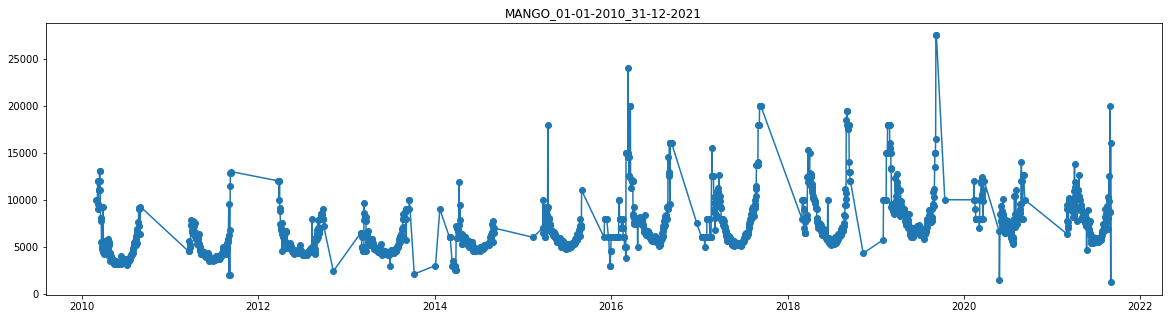

In [457]:
plt.figure(figsize = (20, 5))
plt.title(item_name)

# plt.scatter(mean_df[datetime_column], mean_df[target_column])
plt.plot(mean_df[datetime_column], mean_df[target_column], marker = 'o')

# plt.legend()
plt.show()

# missing date interpolations

In [458]:
class tools():


    def __init__(self, df, price):
        self.df = df
        self.price = price
    

    def add_SMA(self, days = 7):
        col_name = 'SMA_' + self.price + '_' + str(days)
        self.df[col_name] = self.df[self.price].rolling(days).mean()

        return col_name
    

    def add_WMA(self, days = 7):
        weights = np.array(list(range(1, days + 1, 1)))

        col_name = 'WMA_' + self.price + '_' + str(days)
        self.df[col_name] = self.df[self.price].rolling(days).apply(lambda x : np.sum(x * weights) / np.sum(weights))

        return col_name
    

    def add_EMA(self, days = 7):
        sma_part = self.df[self.price][:days].rolling(days).mean()
        original_part = self.df[self.price][days:]
        ema_df = pd.concat([sma_part, original_part])
        
        col_name = 'EMA_' + self.price + '_' + str(days)
        self.df[col_name] = ema_df.ewm(span = days, adjust = False).mean()

        return col_name
    

    def add_DEMA(self, days = 7):
        ema_part = self.add_EMA(days)
        ema_df = self.df[[ema_part]]

        dema_finder = tools(ema_df, ema_part)
        ema_of_ema_part = dema_finder.add_EMA(days)
        ema_of_ema_df = ema_df[ema_of_ema_part]

        dema_df = ema_df[ema_part] * 2
        dema_df -= ema_of_ema_df

        col_name = 'DEMA_' + self.price + '_' + str(days)
        self.df[col_name] = dema_df

        return col_name


    def add_RSI(self, days = 7):
        change = self.df[self.price].diff()
        gain, loss = change, -change
        gain[change < 0] = 0.0
        loss[change > 0] = 0.0

        avg_gain = gain.rolling(days).mean()
        avg_loss = loss.rolling(days).mean()

        rs = avg_gain / avg_loss

        col_name = 'RSI_' + self.price + '_' + str(days)
        self.df[col_name] = 100 - (100 / (1 + rs))

        return col_name


    def add_BB(self, days = 7, multiplier = 2.0):
        col_name = 'BB_' + self.price + '_' + str(days)
        
        sma_part = self.df[self.price].rolling(days).mean()
        std_part = self.df[self.price].rolling(days).std()

        bb_upper = sma_part + multiplier * std_part
        bb_lower = sma_part - multiplier * std_part
        
        self.df[col_name] = [[bb_lower[i], sma_part[i], bb_upper[i]] for i in self.df.index]

        return col_name

In [459]:
mean_copy = mean_df.copy()
mean_copy = mean_copy.set_index(datetime_column).resample('D').interpolate().reset_index()
interpolation_tools = tools(mean_copy, target_column)
dema_col = interpolation_tools.add_DEMA(days = 100)
# mean_copy.head()
# mean_copy = mean_copy.reset_index()

In [460]:
target_column = dema_col

mean_copy = mean_copy.bfill().ffill()

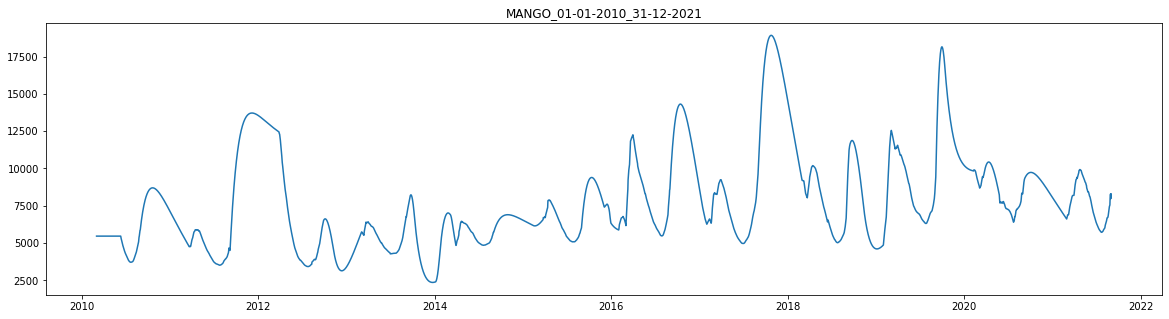

In [461]:
plt.figure(figsize = (20, 5))
plt.title(item_name)

# plt.scatter(mean_df[datetime_column], mean_df[target_column])
plt.plot(mean_copy[datetime_column], mean_copy[target_column])

# plt.legend()
plt.show()

# monthly avg. on mean data

In [462]:
monthly_data = mean_copy.resample('m', on='SearchDate').mean().dropna(how='all').reset_index()

In [463]:
monthly_data.shape

(139, 14)

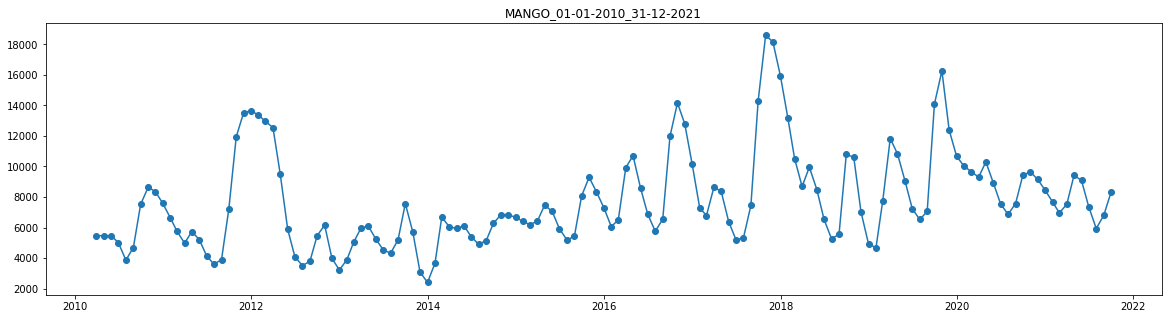

In [464]:
plt.figure(figsize = (20, 5))
plt.title(item_name)

# plt.scatter(mean_df[datetime_column], mean_df[target_column])
plt.plot(monthly_data[datetime_column], monthly_data[target_column], marker = 'o')

# plt.legend()
plt.show()

## splitting

In [465]:
spliter = train_validation_split(df = mean_copy, split_date = split_date)

In [466]:
train_df, validation_df = spliter._time_series_split()

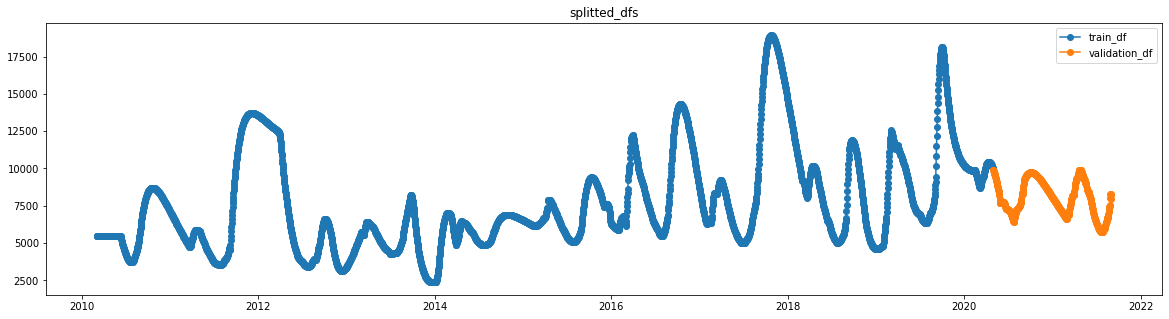

In [499]:
plt.figure(figsize = (20, 5))
plt.title("splitted_dfs")

plt.plot(train_df[datetime_column], train_df[target_column], marker = 'o', label = "train_df")
plt.plot(validation_df[datetime_column], validation_df[target_column], marker = 'o', label = "validation_df")

plt.legend()
plt.show()

### saving train, test dfs

In [468]:

train_df.to_csv("./processed_data/train/" + saving_name + ".csv", index = False)
validation_df.to_csv("./processed_data/validate/" + saving_name + ".csv", index = False)

## pdq finder

d = 0
ADF Statistic: -5.063092
p-value: 0.000017
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Lags Used: 16
Observations: 3696
maximized IC: 34823.778


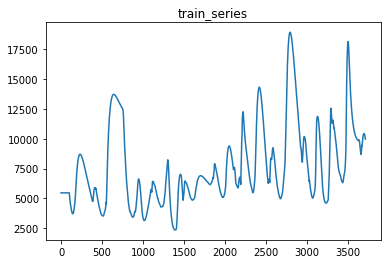

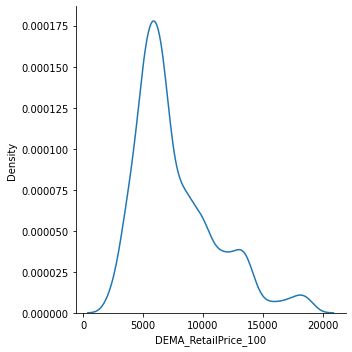

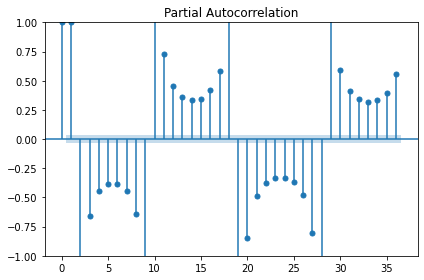

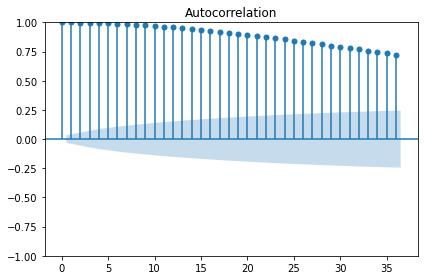

d = 1
ADF Statistic: -8.777519
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Lags Used: 15
Observations: 3696
maximized IC: 34838.947


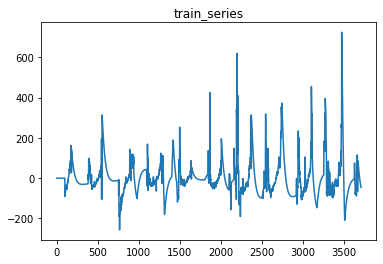

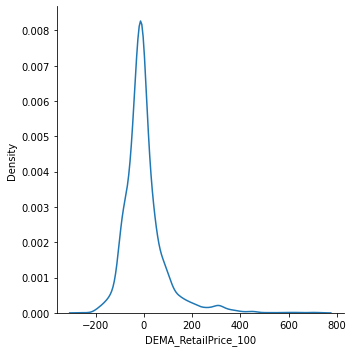

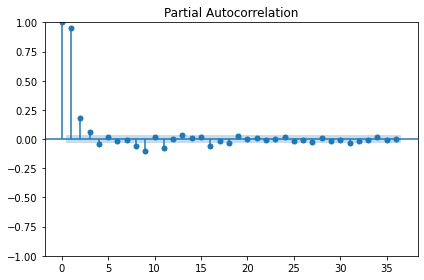

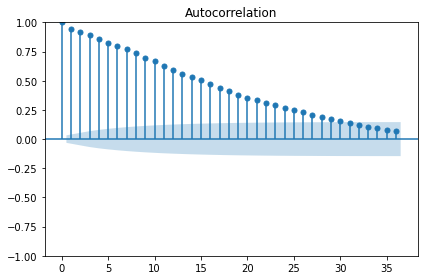

d = 2
ADF Statistic: -14.922896
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Lags Used: 22
Observations: 3688
maximized IC: 34900.527


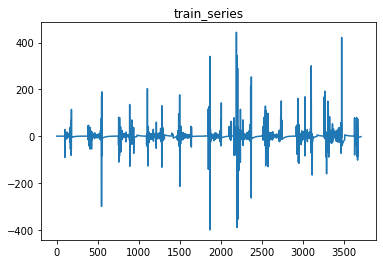

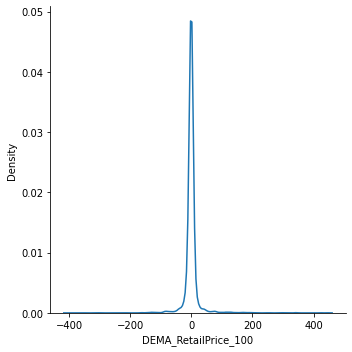

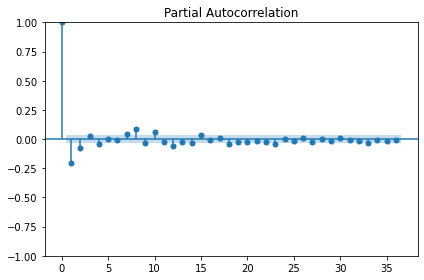

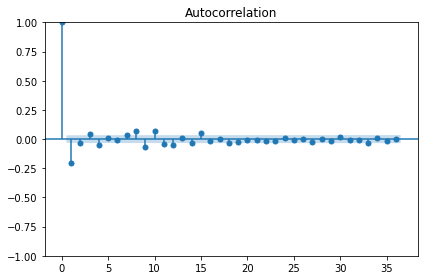

In [469]:
find_pdq(train_df = train_df[[target_column]], target_column = target_column)

## fitting-forecasting

In [470]:
n_window = len(validation_df)
n_start = train_df.last_valid_index() + 2
n_end = n_start + n_window

In [471]:
order_vals = []
for i in order_keys:
    temp_list = i.split(',')
    
    for j in range(len(temp_list)):
        temp_list[j] = int(temp_list[j])

    order_vals.append(tuple(temp_list))
order_dict = dict(zip(order_keys, order_vals))

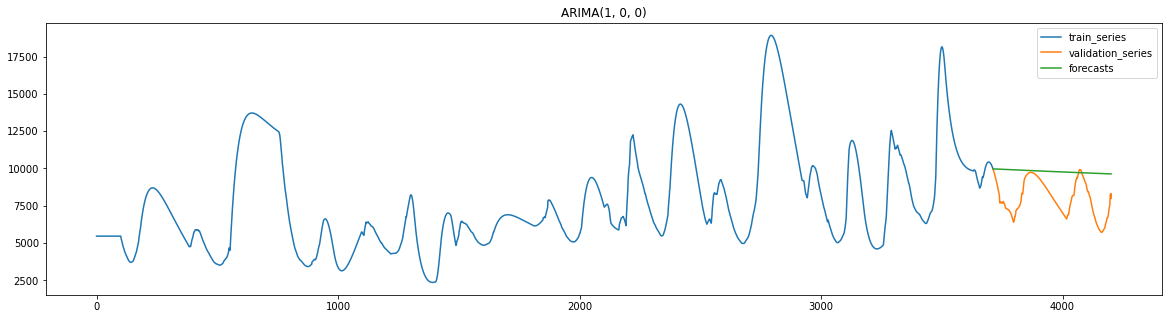

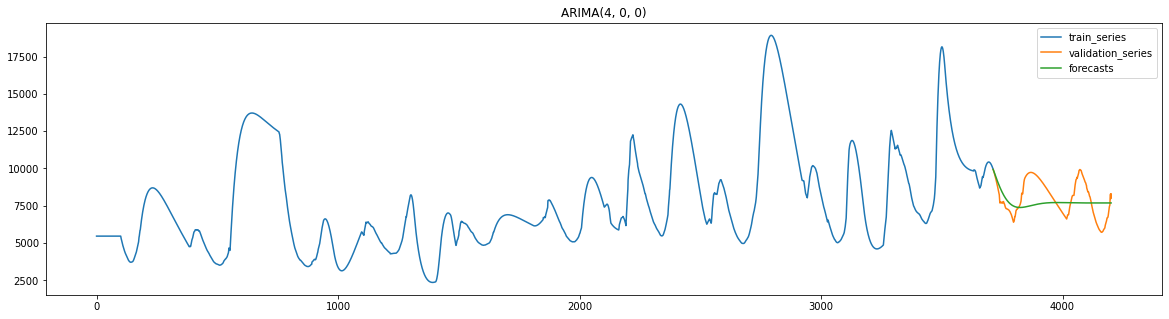

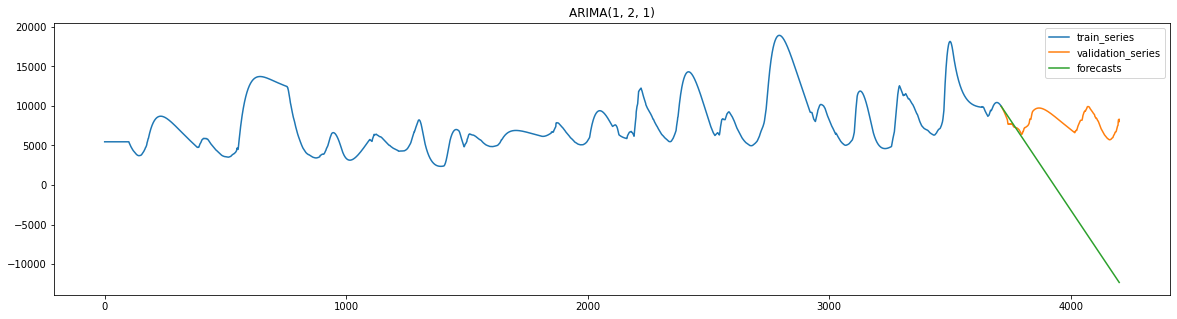

In [472]:
arima_forecast_dict, arima_validation_dict, arima_rmse_forecast_dict, arima_rmse_validation_dict = \
evaluate_multiple_arima(
    order_dict = order_dict, 
    train_series = train_df[target_column], 
    pred_window = n_window, 
    validation_series = validation_df[target_column], 
    plot = True
)

## evaluation-table

In [473]:
mean_eval_table = generate_evaluation_table(
    order_dict = order_dict, 
    arima_forecast_dict = arima_forecast_dict, 
    arima_rmse_forecast_dict = arima_rmse_forecast_dict, 
    pred_window = n_window, 
    validation_series = validation_df[target_column]
)

In [474]:
mean_eval_table

,Model Name,Forecast_1,Original_1,Forecast_2,Original_2,Forecast_3,Original_3,Forecast_4,Original_4,Forecast_5,...,Original_485,Forecast_486,Original_486,Forecast_487,Original_487,Forecast_488,Original_488,Forecast_489,Original_489,RMSE
0,"ARIMA (1, 0, 0)",9970.591627,9923.123833,9969.823382,9872.972202,9969.055451,9820.966331,9968.287833,9767.165589,9967.520529,...,8038.926434,9635.114026,8268.597411,9634.498126,8245.677846,9633.882529,7977.623992,9633.267234,8297.758654,2115.867087
1,"ARIMA (4, 0, 0)",9925.571204,9923.123833,9879.758240,9872.972202,9833.895480,9820.966331,9788.061657,9767.165589,9742.280297,...,8038.926434,7686.814845,8268.597411,7686.839454,8245.677846,7686.863762,7977.623992,7686.887763,8297.758654,1223.686650
2,"ARIMA (1, 2, 1)",9925.723435,9923.123833,9880.127045,9872.972202,9834.533276,9820.966331,9788.939678,9767.165589,9743.346090,...,8038.926434,-12187.169201,8268.597411,-12232.762787,8245.677846,-12278.356374,7977.623992,-12323.949961,8297.758654,11104.180044


In [475]:
mean_eval_table.loc[mean_eval_table[['RMSE']].idxmin(), ['Model Name', 'RMSE']]

,Model Name,RMSE
1,"ARIMA (4, 0, 0)",1223.68665


## auto arima

In [476]:
auto_arima_model = auto_arima(train_df[[target_column]], start_p = 0, start_q = 0)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3713
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -17567.813
Date:                Wed, 04 Jan 2023   AIC                          35149.626
Time:                        20:06:01   BIC                          35193.162
Sample:                             0   HQIC                         35165.117
                               - 3713                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1504      0.055     20.918      0.000       1.043       1.258
ar.L2          0.4486      0.100      4.467      0.000       0.252       0.645
ar.L3         -0.4240      0.042     -9.993      0.000      -0.507      -0.341
ar.L4         -0.1772      0.010    -17.167      0.000      -0.197      -0.157
ma.L1         -0.3837      0.055     -6.946      0.000      -0.492      -0.275
ma.L2         -0.5970      0.055    -10.953      0.000      -0.704      -0.490
sigma2       757.4989      2.967    255.341      0.000     751.684     763.313
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):           1108953.35
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                             3.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        87.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

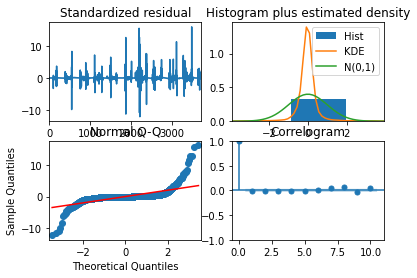

In [477]:
auto_arima_model.plot_diagnostics();

In [478]:

def forecast_to_df(model, steps=12):
    forecast, pred_matrix = model.predict(n_periods = steps, return_conf_int = True)
    pred_df = pd.DataFrame(pred_matrix)
    pred_df['pred'] = forecast
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

In [479]:
pred_df = forecast_to_df(auto_arima_model, steps = len(validation_df))


In [480]:
pred = pred_df['pred']
mse = mean_squared_error(pred, validation_df[target_column])

In [481]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(20,6))
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(range(len(train)+1, len(train) + len(test) + 1), pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=range(len(train)+1, len(train) + len(test) + 1),y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    plt.show()
    return fig,ax

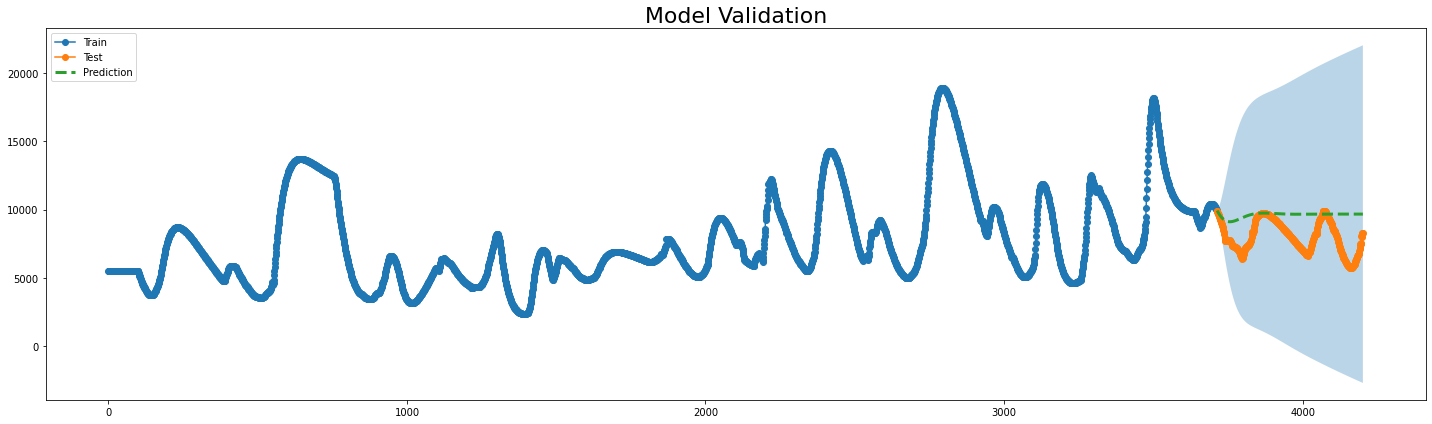

(<Figure size 1440x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Model Validation'}>)

In [482]:
plot_train_test_pred(train_df[[target_column]], validation_df[[target_column]], pred_df)

# stl decomposition

In [483]:
def seaonal_grid_search(n_periods, train_df, target_column, stl = False, mode = "additive"):
    least_rmse = 1e8
    best_period = -1

    if (stl == True):
        mode = "additive"


    for n_period in n_periods:
        print(n_period)
        if (stl == False):
            result = seasonal_decompose(train_df[target_column], model=mode, period = n_period)
        else:
            result = STL(train_df[target_column], period = n_period).fit()
        
        if (mode == "multiplicative"):
            season_adjusted = train_df[target_column] / result.seasonal
        else:
            season_adjusted = train_df[target_column] - result.seasonal
        train_df['adjusted'] = season_adjusted

        seasonal_pred = []
        for i in range(len(result.seasonal) + 1, len(result.seasonal) + 1 + len(validation_df)):
            seasonal_pred.append(result.seasonal[i % n_period])
        
        auto_arima_model = auto_arima(train_df[['adjusted']], start_p = 0, start_q = 0)
        pred_df = forecast_to_df(auto_arima_model, steps = len(validation_df))
        
        if mode == "multiplicative":
            pred_df['pred'] *= seasonal_pred
        else:
            pred_df['pred'] += seasonal_pred
        
        pred = pred_df['pred']

        plot_train_test_pred(train_df[[target_column]], validation_df[[target_column]], pred_df)
        
        pred_np = pred.to_numpy()
        actual = validation_df[target_column].to_numpy()
        
        mse = mean_squared_error(pred_np, actual)
        rmse =  np.sqrt(mse)
        mape = np.abs((pred_np - actual) / actual).mean()
        print(mape)

        if mape < least_rmse:
            least_rmse = mape
            best_period = n_period
    
    return best_period, least_rmse

360


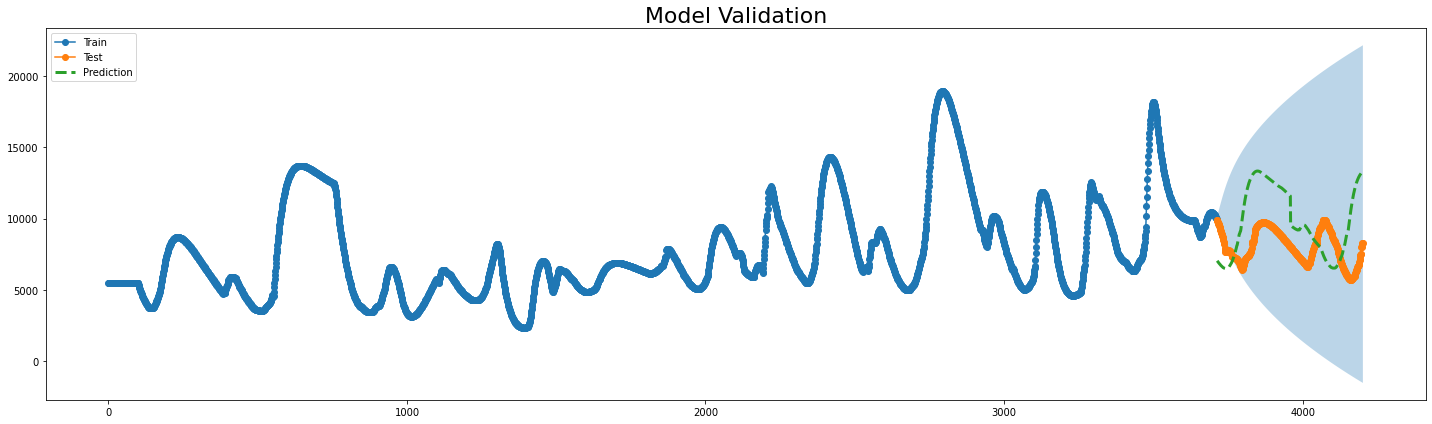

0.355929318242191
362


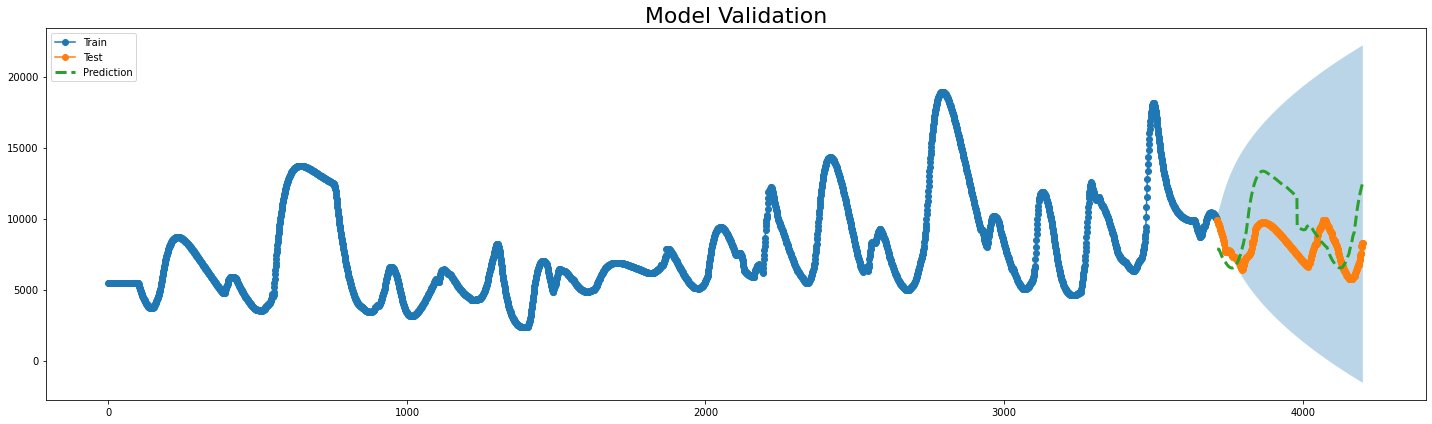

0.2960893025055935
364


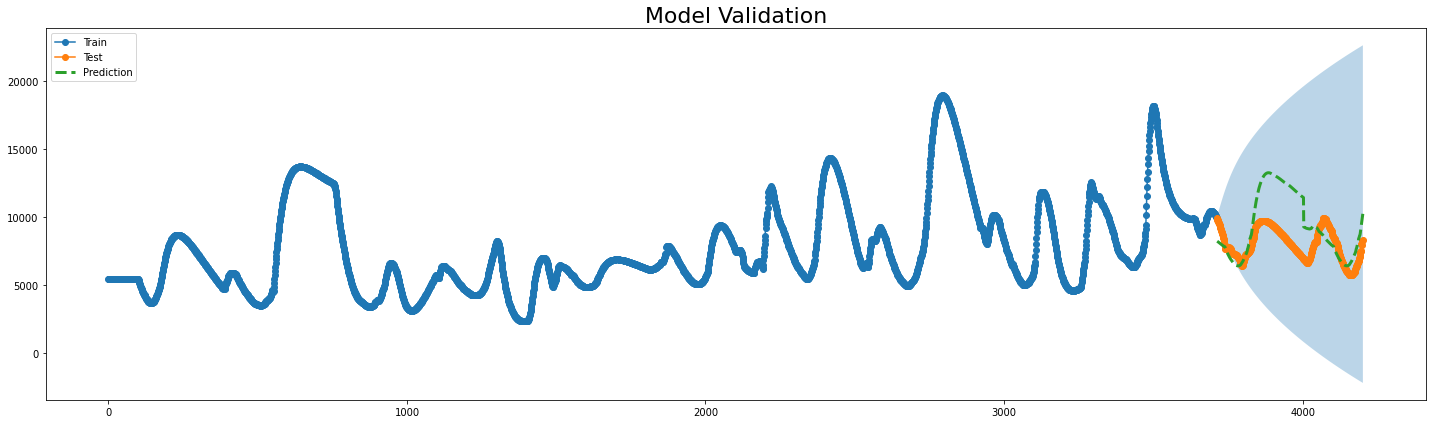

0.23070236740048095
366


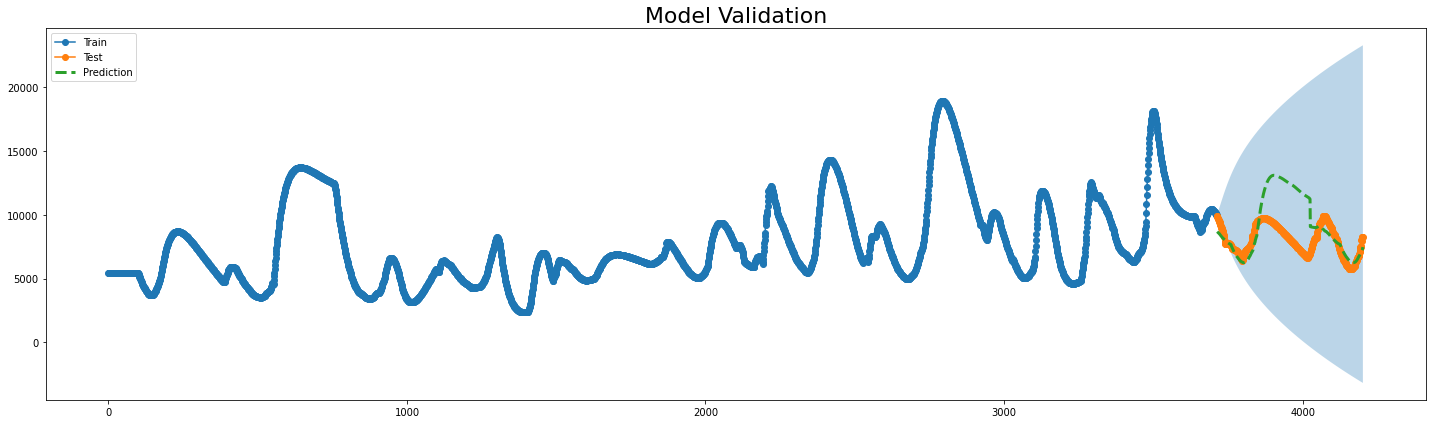

0.21328313321313938
368


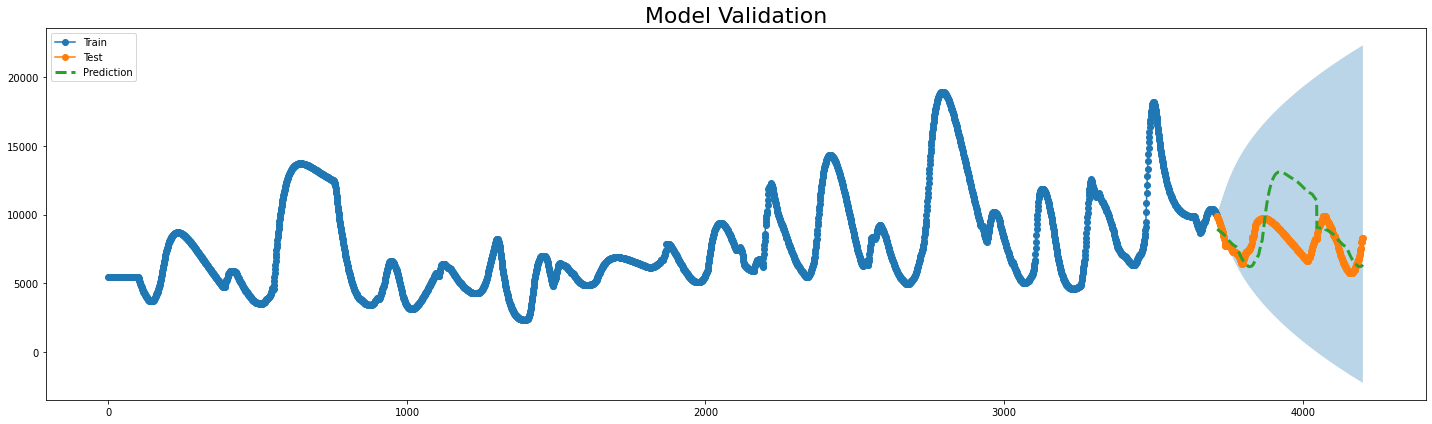

0.2497760996138353


In [484]:
season_size, least_rmse = seaonal_grid_search(range(360, 370, 2), train_df, target_column, stl=True)

In [485]:
print(season_size, least_rmse)

366 0.21328313321313938


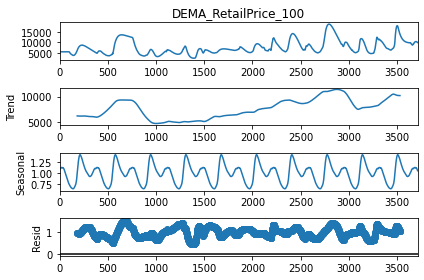

In [486]:
result = seasonal_decompose(train_df[target_column], model='multiplicative', period = season_size)
result.plot();
plt.show()

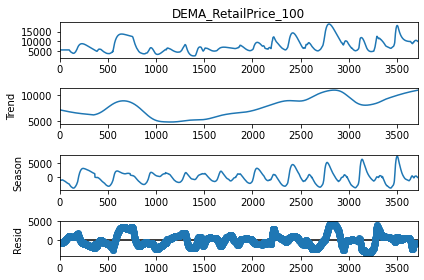

In [487]:

res = STL(train_df[target_column], period = season_size).fit()
res.plot()
plt.show()

In [488]:
# season_adjusted = train_df[target_column] - result.seasonal

In [489]:
# plt.figure(figsize=(20, 6))
# plt.plot(season_adjusted)
# plt.show()

In [490]:
# train_df['adjusted'] = season_adjusted

In [491]:
# seasonal_pred = []
# for i in range(len(result.seasonal) + 1, len(result.seasonal) + 1 + len(validation_df)):
#     seasonal_pred.append(result.seasonal[i % season_size])

In [492]:
# auto_arima_model = auto_arima(train_df[['adjusted']], start_p = 0, start_q = 0)
# auto_arima_model.summary()

In [493]:
# pred_df = forecast_to_df(auto_arima_model, steps = len(validation_df))

In [494]:
# plt.figure(figsize=(20, 6))
# plt.plot(train_df['adjusted'])
# plt.plot(range(len(train_df['adjusted']) + 1, len(pred_df['pred']) + 1 + len(train_df['adjusted'])), pred_df['pred'])
# plt.show()

In [495]:
# plt.figure(figsize=(20, 6))

# plt.plot(result.seasonal)
# plt.plot(range(len(result.seasonal) + 1, len(result.seasonal) + 1 + len(validation_df)), seasonal_pred)

# plt.show()

In [496]:
# pred_df['pred'] += seasonal_pred
# pred = pred_df['pred']
# mse = mean_squared_error(pred, validation_df[target_column])

In [497]:
# plot_train_test_pred(train_df[[target_column]], validation_df[[target_column]], pred_df)

In [498]:
# rmse =  np.sqrt(mse)
# print("rmse:: ", rmse)